# 1. 효율적인 데이터 표현

- 인코더 : 입력을 내부 표현으로 변경
- 디코더 : 내부 표현을 출력으로 변경
- 오토인코더 : 입력 재구성
- 과소완전(Undercomplete) : 내부 표현이 입력 데이터보다 저차원인 오토인코더

# 2. 과소완전 선형 오토인코더로 PCA 수행하기

- 주성분 분석 수행과 비슷

# 3. 적층 오토인코더(Stacked Autoencoder)

- 오토인코더가 은닉층을 여러 개 가진 것, 심층 오토인코더
- 케라스로 적층 오토인코더 구현하기
- 재구성 시각화
- 패션 MNIST 데이터셋 시각화
- 적층 오토인코더를 사용한 비지도 사전 훈련
- 가중치 묶기
- 오토인코더 한 개씩 훈련하기

## 4. 합성곱 오토인코더(Convolutional Autoencoder)

- 이미지에 대한 오토인코더
- 전치 합성곱 층 사용
- 과대완전 오토인코더(Overcomplete Autoencoder) : 입력 크기만큼 또는 입력보다 큰 코딩 층

# 5. 잡음 제거 오토인코더(Stacked Denoising Autoencoder)

- 입력에 순수한 가우스 잡음을 추가
- 드롭아웃처럼 랜덤으로 입력에 주입

# 6. 희소 오토인코더(Sparsity Autoencoder)

- 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수 감소
- 코딩 층에 시그모이드 활성화 함수 사용, 큰 코딩 층 사용
- 희소 손실(Sparsity Loss) : 과대 활성화, 과소 활성화 뉴런에 벌칙 주입

# 7. 변이형 오토인코더(Variational Autoencoder)

- 확률적 오토인코더 → 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정
- 생성 오토인코더 → 훈련 세트에서 샘플링된 것 같은 새로운 샘플 생성 가능
- 시맨틱 보간(Semantic Interpolation) : 픽셀 수준의 보간 대신 코딩 수준의 이미지 보간

# 8. 생성적 적대 신경망

- 생성자 → 랜덤한 분포를 입력으로 받고 이미지와 같은 데이터 출력
- 판별자 → 생성자에서 얻은 이미지를 입력으로 받아 입력된 이미지가 가짜인지 진짜인지 판별
- 내시 균형(Nash Equilibrium) : 어떤 플레이어도 자신의 전략을 수정하지 않으려는 상태
- 모드 붕괴(Mode Collapse) : 생성자의 출력 다양성 감소
- 경험 재생(Experience Replay) : 매 반복에서 생성자가 만든 이미지를 재생 버퍼에 저장, 실제 이미지와 가짜 이미지를 더해서 판별자 훈련
- 미니배치 판별(Mini-Batch Discrimination) : 배치 간에 얼마나 비슷한 이미지가 있는지 측정하여 판별자에 제공
- 심층 합성곱 GAN(DCGAN, Deep Convolutional GAN)
- ProGAN : 미니배치 표준 편차 층 + 픽셀별 정규화 층
- StyleGAN : 매핑 네트워크 + 합성 네트워크

# 9. 확산 모델

- 잡음 제거 확산 확률 모델(DDPM, Denoising Diffusion Probabilistic Model)
- 잠재 확산 모델(Latent Diffusion Model) : 확산 과정이 픽셀 공간이 아닌 잠재 공간에서 일어남

In [1]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m, 3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]

In [3]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


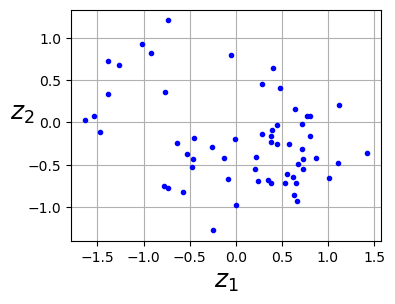

In [4]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
tf.random.set_seed(42)

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0338 - val_loss: 0.0183
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0175 - val_loss: 0.0169
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0145 - val_loss: 0.0146
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 12/20
1719/1719 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


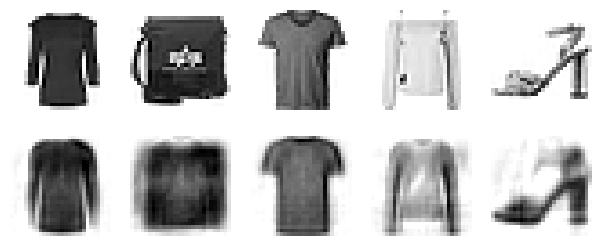

In [7]:
import numpy as np


def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


plot_reconstructions(stacked_ae)
plt.show()

In [8]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


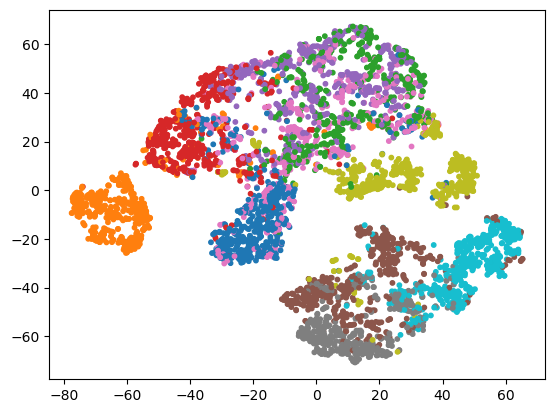

In [9]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

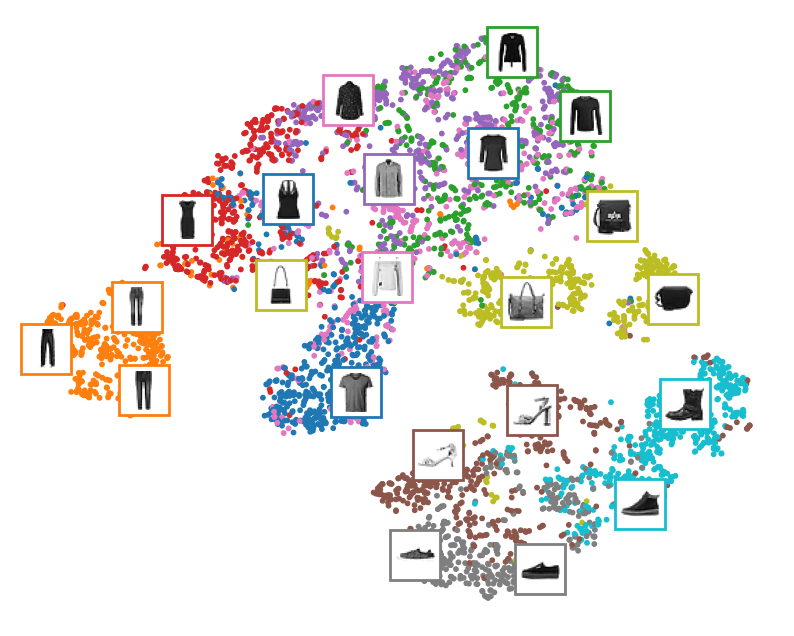

In [10]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"), position,
                                                bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

In [11]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", shape=self.dense.input_shape[-1], initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [15]:
tf.random.set_seed(42)

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


AttributeError: 'Dense' object has no attribute 'input_shape'

In [16]:
plot_reconstructions(tied_ae)
plt.show()

ValueError: Sequential model 'sequential_17' has already been configured to use input shape (None, 28, 28). You cannot build it with input_shape (5, 28, 28)

In [17]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10, output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [18]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0304 - val_loss: 0.0114
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 0.1387 - val_loss: 0.0538
Epoch 2/10
1719/1719 ━━━━━━━━

In [19]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


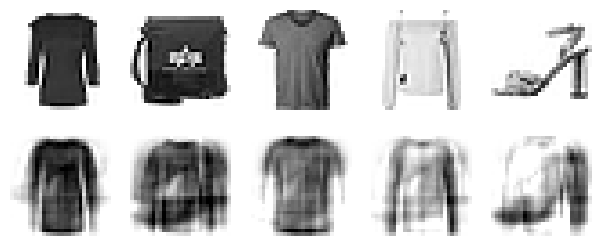

In [20]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [21]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0144 - val_loss: 0.0143
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0141 - val_loss: 0.0141


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


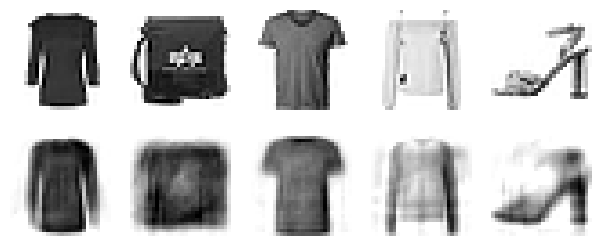

In [22]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0463 - val_loss: 0.0212
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0200 - val_loss: 0.0182
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0150 - val_loss: 0.0147
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0126 - val_loss: 0.0126


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


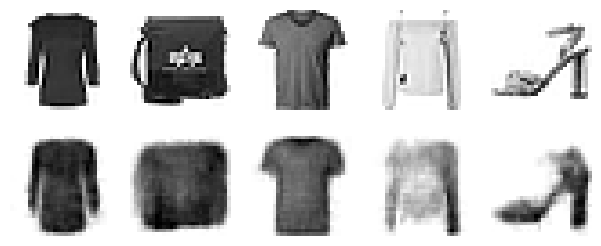

In [24]:
plot_reconstructions(conv_ae)
plt.show()

In [25]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [26]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - loss: 0.0366 - val_loss: 0.0193
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 57s 33ms/step - loss: 0.0186 - val_loss: 0.0164
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 54s 31ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - loss: 0.0109 - val_loss: 0.0107


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


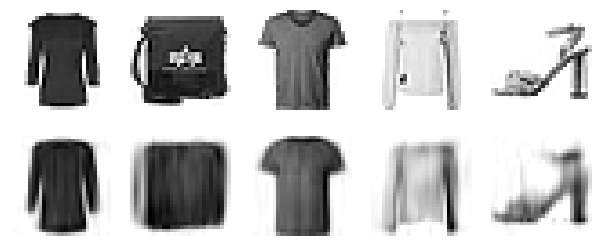

In [27]:
plot_reconstructions(recurrent_ae)
plt.show()

In [28]:
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0391 - val_loss: 0.0213
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0223 - val_loss: 0.0197
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0210 - val_loss: 0.0189
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0199 - val_loss: 0.0181
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0195 - val_loss: 0.0178
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0188 - val_loss: 0.0172


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


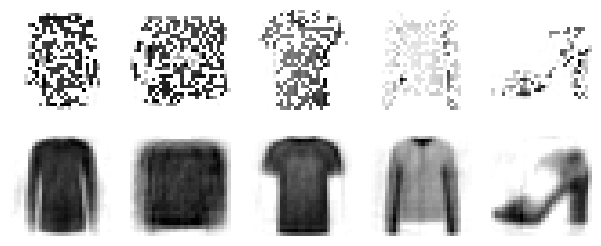

In [29]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

In [30]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0801 - val_loss: 0.0316
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0294 - val_loss: 0.0269
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0262 - val_loss: 0.0247
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0242 - val_loss: 0.0242
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0227 - val_loss: 0.0223
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0216 - val_loss: 0.0212
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0208 - val_loss: 0.0203
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0201 - val_loss: 0.0199
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0191 - val_loss: 0.0189


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


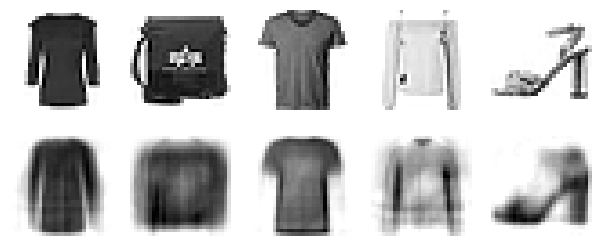

In [31]:
plot_reconstructions(sparse_l1_ae)
plt.show()

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

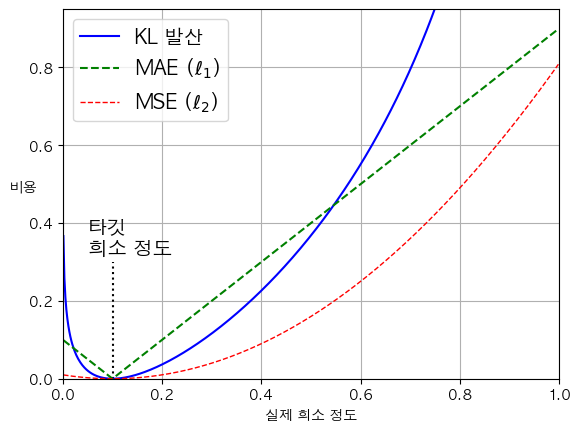

In [34]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "타깃\n희소 정도", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

In [35]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence


class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
                kl_divergence(self.target, mean_activities) +
                kl_divergence(1. - self.target, 1. - mean_activities))

In [36]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0705 - val_loss: 0.0226
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0161 - val_loss: 0.0164
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0099 - val_loss: 0.0104


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


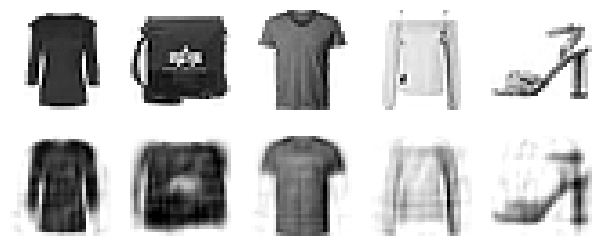

In [37]:
plot_reconstructions(sparse_kl_ae)
plt.show()

In [38]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [39]:
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [40]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [41]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

ValueError: When providing `outputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: outputs=[[<KerasTensor shape=(None, 28, 28), dtype=float32, sparse=False, name=keras_tensor_139>]] including invalid value [<KerasTensor shape=(None, 28, 28), dtype=float32, sparse=False, name=keras_tensor_139>] of type <class 'list'>

In [42]:
latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [43]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

NameError: name 'variational_ae' is not defined

In [44]:
plot_reconstructions(variational_ae)
plt.show()

NameError: name 'variational_ae' is not defined

In [45]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

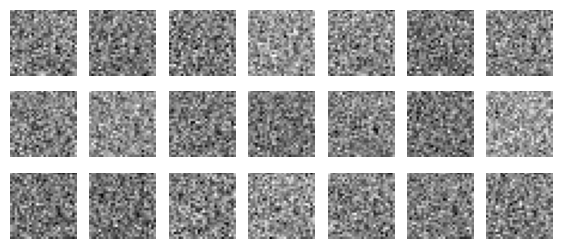

In [46]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


plot_multiple_images(images, 7)
plt.show()

In [47]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()

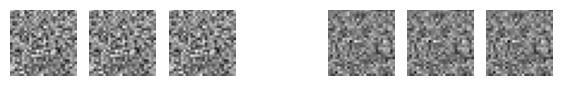

In [48]:
plot_multiple_images(images)
plt.show()

In [49]:
tf.random.set_seed(42)

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [50]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [51]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [52]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"에포크 {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()


train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

에포크 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


KeyboardInterrupt: 

In [53]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


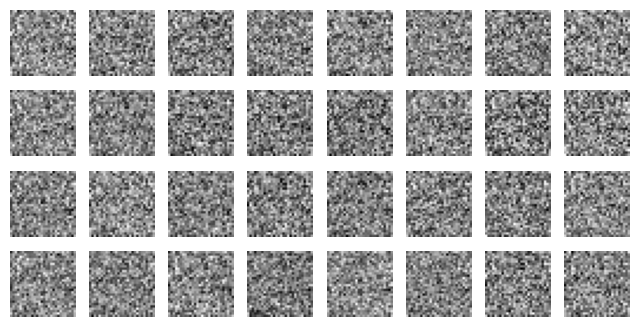

In [54]:
plot_multiple_images(generated_images, 8)
plt.show()

In [55]:
tf.random.set_seed(42)

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [56]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [57]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [58]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

에포크 1/10


KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


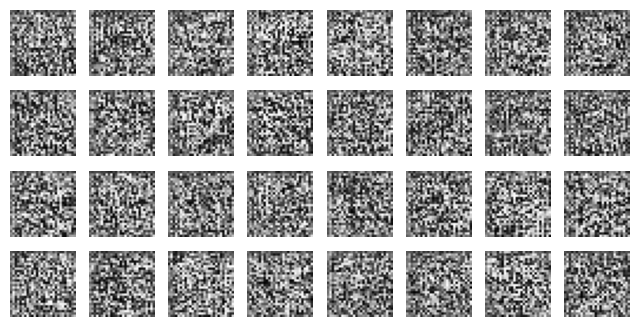

In [59]:
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

In [60]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta


np.random.seed(42)
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

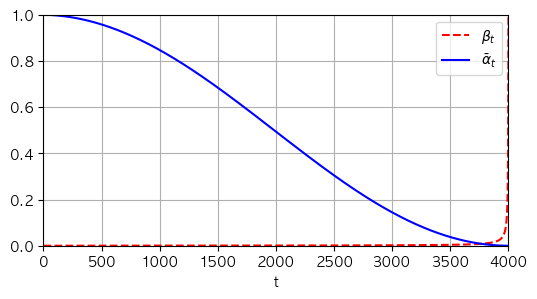

In [61]:
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
plt.show()

In [62]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

In [63]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)


tf.random.set_seed(43)
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

원본 이미지


2024-06-28 18:21:48.238209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


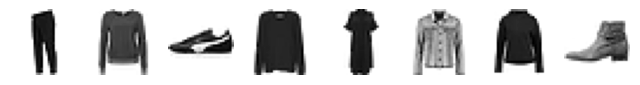

타임 스텝: [3405  312 3441 1991 2443 1657 3308 1151]
잡음 이미지


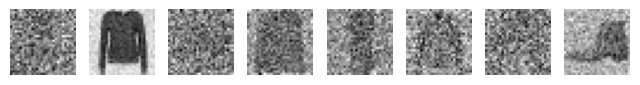

예측할 잡음


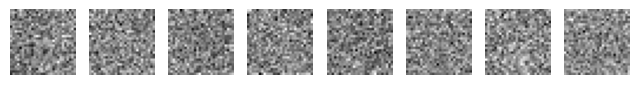

In [64]:
def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5


X_dict, Y_noise = list(train_set.take(1))[0]
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("원본 이미지")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("타임 스텝:", X_dict["time"].numpy()[:8])
print("잡음 이미지")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("예측할 잡음")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

In [65]:
embed_size = 64


class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

In [66]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z

    skip = Z
    cross_skips = []

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [67]:
tf.random.set_seed(42)
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[checkpoint_cb])

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=my_diffusion_model

In [68]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
                1 / alpha[t] ** 0.5
                * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
                + (1 - alpha[t]) ** 0.5 * noise
        )
    return X


tf.random.set_seed(42)
X_gen = generate(model)

t = 1    

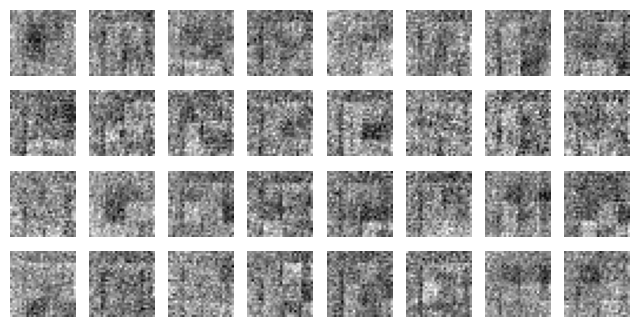

In [69]:
plot_multiple_images(X_gen.numpy(), 8)
plt.show()

In [70]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

ValueError: Invalid value received for argument `stddev`. Expected a float value between 0 and 1. Received: stddev=15.0

In [71]:
plot_reconstructions(hashing_ae)
plt.show()

NameError: name 'hashing_ae' is not defined

In [72]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

NameError: name 'hashing_encoder' is not defined

In [73]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

NameError: name 'hashes' is not defined